# **<font color='crimson'>ПРОЕКТ «Прогнозирование количества заказов такси на следующий час для компании „ Чётенькое такси ‟»</font>**

---

**Выполнил**: Юмаев Егор


## <font color='green'>**Введение. Описание проекта, его цель и задачи**</font>

---

В компании **«Чётенькое такси»** были собраны исторические данные о заказах такси в аэропортах. Для улучшения финансовых показателей деятельности компании требуется привлекать больше водителей в периоды пиковых нагрузок. Соответственно, требуется спрогнозировать количество заказов такси на следующий час и на основе полученных прогнозов планировать привлечение водителей.

Ключевая особенность собранных данных – они распределены по временным интервалам, поэтому решаемая задача будет относиться к **анализу временных рядов**.

**Цель проекта**: построить модель, предсказывающую количество заказов такси на следующий час.

**Целевое ограничение, по которому оценивается результат выполнения проекта**: значение метрики **RMSE** лучшей модели на тестовой выборке должно быть **<= 48**.

Для достижения цели были поставлены и решены следующие **задачи**:

 * выполнена загрузка и ресемплирование данных по одному часу;

 * проведен исследовательский анализ данных;

 * обучены модели машинного обучения с разными гиперпараметрами с выделением тестовой выборки в размере 10% от исходных данных;

 * лучшая модель проверена на тестовой выборке.

Решаемая задача относится к категории задач **регрессии**.

## <font color='green'>**1 Загрузка данных и их ресэмплирование**</font>

---

### **1.1 Импорт необходимых библиотек, структур данных и функций. Загрузка данных**

---

In [1]:
# устанавливаем библиотеку catboost, модель из которой
# потребуется для машинного обучения
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [2]:
# импортируем необходимые библиотеки, структуры данных и функции

# основные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault

# анализ трендов и сезонности
from statsmodels.tsa.seasonal import seasonal_decompose

# подготовка к машинному обучению
from sklearn.model_selection import train_test_split

# кроссвалидация
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# модели машинного обучения
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

# метрики машинного обучения
from sklearn.metrics import mean_squared_error

# убираем 'красные' предупреждения
import warnings
warnings.filterwarnings("ignore")

In [3]:
# настраиваем параметры отображения рисунков
rcParams['figure.figsize'] = 12,12
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
factor = 10
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

In [4]:
# для того, чтобы обеспечить "читаемость" всех столбцов,
# применим функцию pd.set_option()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# подгружаем файл с данными, обеспечивая преобразование типа данных
# в столбце с датой в формат datetime с указанием его как столбца с индексами
try:
    data = pd.read_csv('/datasets/taxi.csv',
                       parse_dates = [0],
                       index_col = [0])

    print('Datasets load from Practicum cloud')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',
                       parse_dates = [0],
                       index_col = [0])

    print('Datasets load from Web')

Datasets load from Web


In [6]:
# проверим, загружены ли данные, для чего выведем первые пять строк датасета
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### **Выводы по 1.1 Импорт необходимых библиотек, структур данных и функций. Загрузка данных**

---

(1) необходимые библиотеки, структуры данных и функции импортированы; настроены параметры отображения рисунков

(2) данные загружены и готовы для исследовательского анализа

(3) при загрузке данных обеспечено преобразование типа данных в столбце с информацией о дате и времени в datetime с указанием его как столбца с индексами датасета

### **1.2 Ресэмплирование данных по одному часу**

---

In [7]:
# проверим, за какое количество дней представлена информация
# в датасете о заказах такси
unique_number_dates = len(np.unique(data.index.date))
print(f'В датасете представлена информация о заказах такси за {unique_number_dates} дня')

В датасете представлена информация о заказах такси за 184 дня


Как видим, в нашем распоряжении данные о количестве заказов такси за полгода.

Выведем информацию о самой ранней и самой поздней дате заказа такси за анализируемый период.

In [8]:
print(f'Самая ранняя дата заказа такси \n {data.index.min()}')
print('-------------------------------')
print(f'Самая поздняя дата заказа такси \n {data.index.max()}')

Самая ранняя дата заказа такси 
 2018-03-01 00:00:00
-------------------------------
Самая поздняя дата заказа такси 
 2018-08-31 23:50:00


В датасете представлена информация о заказе такси с 1 марта 2018 г. по 31 августа 2018 г.

In [9]:
# проверим, расположены ли даты в датасете в хронологическом порядке
data.index.is_monotonic

True

Даты расположены в хронологическом порядке, поэтому их сортировка по возрастанию не требуется.

Визуализируем распределение данных до ресэмплирования.

In [10]:
# создадим функцию для визуализации временного ряда
def time_series_picture(data, style, color, title):
    with plt.style.context(style):
        plt.figure(figsize = (8, 5))
        plt.plot(data, color = color)
        plt.xlabel('Дата')
        plt.ylabel('Количество заказов')
        plt.title(title)
        plt.show()

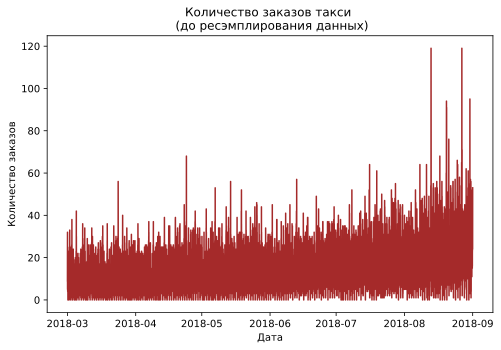

In [11]:
# построим рисунок с распределением данных до ресэмплирования
time_series_picture(data,
    'seaborn-deep',
    'brown',
    'Количество заказов такси \n (до ресэмплирования данных)')

Ресэмплируем данные по одному часу, т.к. предсказать требуется количество заказов такси на следующий час. Количество заказов по каждому часу будет просуммировано, т.к. согласно техзадания предсказать требуется именно количество заказов такси, а не среднее количество вызовов.

In [12]:
# ресэмплируем данные по одному часу
# с расчетом суммы количества заказов за час
data_resampled = data.resample('1H').sum()

Визуализируем распределение данных после ресэмплирования.

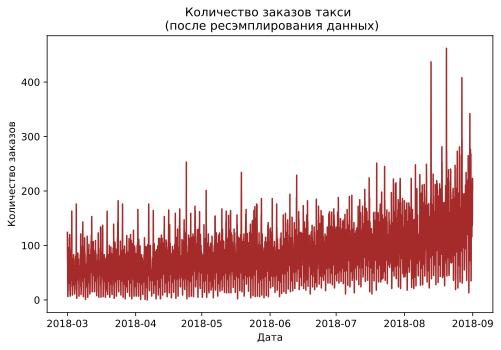

In [13]:
# построим рисунок с распределением данных после ресэмплирования
time_series_picture(data_resampled,
    'seaborn-deep',
    'brown',
    'Количество заказов такси \n (после ресэмплирования данных)')

Ресэмплирование (группировка) была сделана по одному часу, поэтому 'читаемость' графика, отражающего заказы такси за полгода, после аггрегирования не сильно улучшилась. В последующих разделах проекта будет представлен еще ряд графиков.

In [14]:
# для оптимизации загрузки оперативной памяти удалим датасет data
del data

### **Выводы по 1.2 Ресэмплирование данных по одному часу**

---

**(1)** данные датасета ресэмплированы по одному часу с расчетом среднего количества заказов такси

**(2)** построены рисунки, отражающие распределение количества заказов такси до и после ресэмплирования данных

## **<font color='mediumblue'>ВЫВОДЫ по 1 Загрузка данных и их ресэмплирование</font>**

---

**(1)** импортированы необходимые библиотеки, структуры данных и функции

**(2)** данные загружены

**(3)** проведено ресэмплирование данных по одному часу с визуализаций распределения до и после ресэмплирования

## <font color='green'>**2 Исследовательский анализ данных**</font>

---

### **2.1 Общее знакомство с данными**

---

Т.к. согласно техзадания ресемплирование датасета было проведено в первой части исследования, исследовательский анализ данных будет выполнен на датасете data_resampled.

In [15]:
# проверим размер датасета (число строк и колонок / общее число ячеек)
data_resampled.shape, data_resampled.size

((4416, 1), 4416)

Датасет не отличается большими размерами. Количество наблюдений немного превышает 4.4 тысячи. Даже после создания признаков для обучения регрессионных моделей процесс обучения будет быстрым.

In [16]:
# проверим тип данных в столбцах
data_resampled.dtypes

num_orders    int64
dtype: object

Тип данных столбца, отражающего количество заказов, целочисленный, - этот тип подходит для машинного обучения и не требует изменения.

In [17]:
# посмотрим общую статистику о датасете
data_resampled.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Среднее количество заказов такси в час: 84 заказов. Медианное количество заказов равно 78. В самые пиковые часы число заказов в час может составлять до 462. Также видим, что есть часы с нулевым количеством заказов.

Проверим, есть ли пропуски в датасете.

In [18]:
# проверим наличие пропусков в датасете
data_resampled.isna().sum() / data_resampled.shape[0] * 100

num_orders    0.0
dtype: float64

Пропуски в датасете отсутствуют.

In [19]:
# проверим наличие явных дубликатов
data_resampled.duplicated().sum()

4165

Дубликатов много, впрочем, проверка дат на хронологию показала, что дублирующих дат нет. Среднее число заказов такси варьируется в ограниченном диапазоне, поэтому не удивительно, что было обнаружено много дубликатов. Удалять дубликаты не будем: в случае с временным рядом все они необходимы для обучения модели.

### **Выводы по 2.1 Общее знакомство с данными**

---

**(1)** исследовательский анализ данных не позволил выявить серьезных недостатков, требующих проведения предобработки и коррекции датасета

### **2.2 Анализ временных рядов датасета**

---

Проанализируем тренды и сезонность данных.

In [20]:
# передав функции seasonal_decompose ресэмплированный датасет,
# получим атрибуты, отражающие тренд, сезонность и остатки (шум)
decomposed = seasonal_decompose(data_resampled)

Визуализируем три атрибута, полученные после работы функции seasonal_decompose.

In [21]:
# создадим функцию для визуализации результатов декомпозиции
def decomposed_picture(data, style, color, title):
    plt.style.use(style)
    plt.figure(figsize = (8, 2))
    data.plot(ax = plt.gca(), color = color)
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.title(f'Анализ декомпозиции: {title}')
    plt.show()

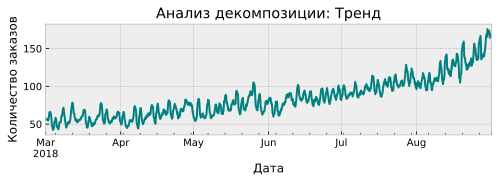

In [22]:
# выведем рисунок, отображающий тренд
decomposed_picture(
    decomposed.trend,
    'bmh',
    'teal',
    'Тренд'
)

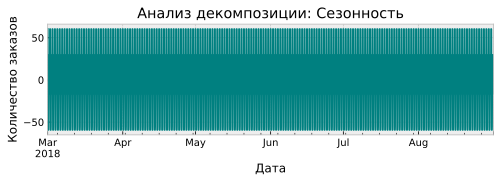

In [23]:
# выведем рисунок, отображающий сезонность
decomposed_picture(
    decomposed.seasonal,
    'bmh',
    'teal',
    'Сезонность'
)

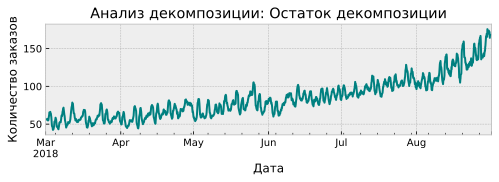

In [24]:
# выведем рисунок, отображающий остаток декомпозиции
decomposed_picture(
    decomposed.trend,
    'bmh',
    'teal',
    'Остаток декомпозиции'
)

График, отображающий тренд, позволяет сделать вывод, что количество заказов такси увеличивается в летние месяцы, особенно в августе, - на этот период приходится пик летних отпусков, поэтому люди чаще летают самолетом и заказывают такси до аэропорта.

Остаток декомпозиции - это шумовые данные, анализировать их смысла нет.

График, отображающий сезонность, не подходит для анализа (не 'читается'). Т.к. исследуемый период охватывает всего шесть месяцев, сделаем срезы по месяцам и рассмотрим динамику сезонности в течении каждого месяца.

In [25]:
slice_mar = [slice('2018-03-01 00:00:00', '2018-03-31 23:50:00'), 'Март']
slice_apr = [slice('2018-04-01 00:00:00', '2018-04-30 23:50:00'), 'Апрель']
slice_may = [slice('2018-05-01 00:00:00', '2018-05-31 23:50:00'), 'Май']
slice_jun = [slice('2018-06-01 00:00:00', '2018-06-30 23:50:00'), 'Июнь']
slice_jul = [slice('2018-07-01 00:00:00', '2018-07-31 23:50:00'), 'Июль']
slice_aug = [slice('2018-08-01 00:00:00', '2018-08-31 23:50:00'), 'Август']

In [26]:
# создадим список отобранных индексов дат
slice_per_month = [slice_mar, slice_apr, slice_may,
                   slice_jun, slice_jul, slice_aug]

In [27]:
# создадим функцию для вывода результатов сезонности по месяцам
def decomposed_seasonal_picture(data, slices, style, color):
    for i in slices:
        plt.style.use(style)
        plt.figure(figsize = (8, 2))
        data[i[0]].plot(ax = plt.gca(), color = color)
        plt.xlabel('Дата')
        plt.ylabel('Количество заказов')
        plt.title(f'Анализ сезонности:\n {i[1]}')
        plt.show()

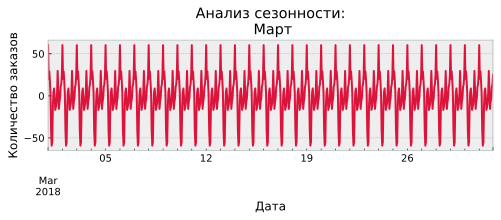

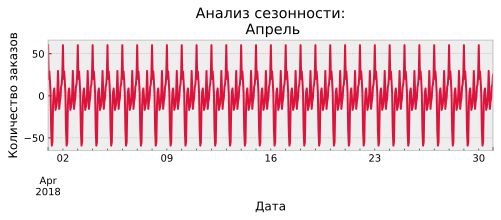

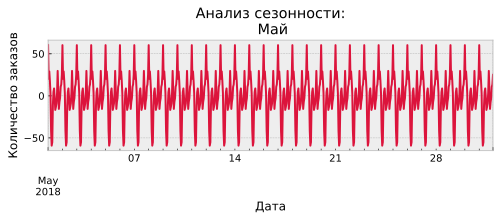

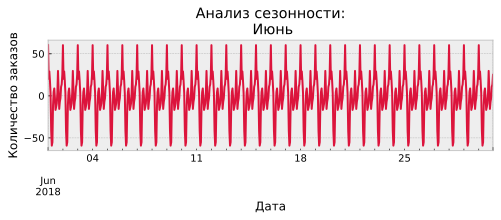

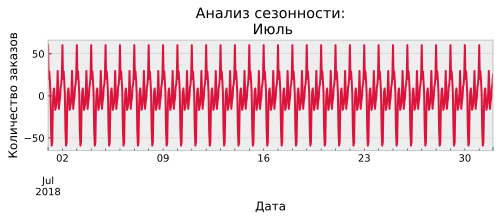

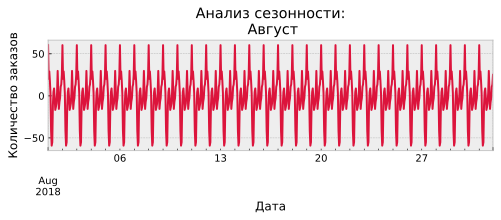

In [28]:
decomposed_seasonal_picture(
    decomposed.seasonal,
    slice_per_month,
    'bmh',
    'crimson'
)

Результаты по каждому месяцу в отдельности дают примерно одинаковые результаты: ежедневно после полуночи количество заказов такси резко сокращается. Рост начинается в середине дня и достигает пика с 22 до 24 часов.

Проведем дополнительную проверку датасета на стационарность. Для этого с помощью функции rolling() сгруппируем данные и посчитаем среднеее и стандартное отклонение до и после выравнивания данных с помощью функции shift().

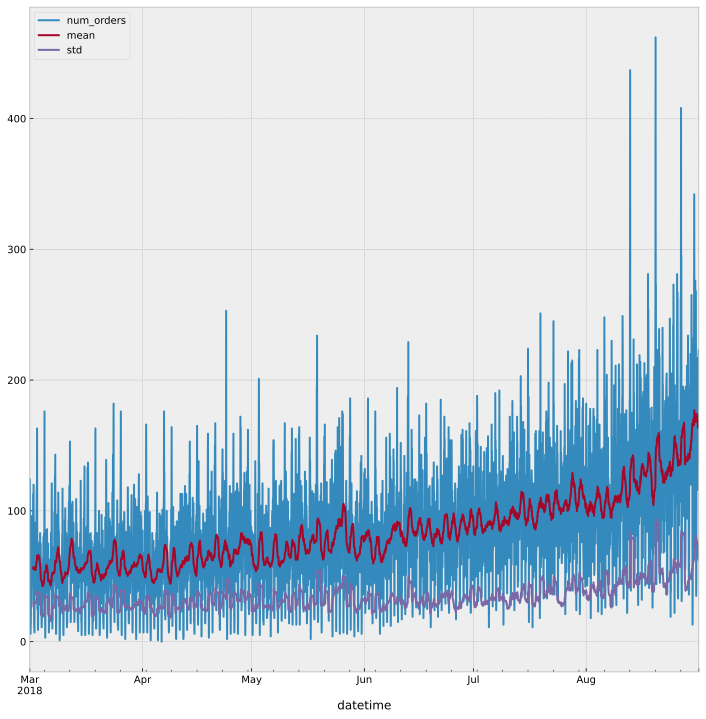

In [29]:
# визуализируем распределение данных до выравнивания: на одном графике
# изобразим распределение данных, среднее количество заказов такси
# и стандартное отклонение

data_temp = data_resampled.copy()
data_temp['mean'] = data_temp['num_orders'].rolling(24).mean()
data_temp['std'] = data_temp['num_orders'].rolling(24).std()
data_temp.plot()
plt.show()

Сдвинем все значения вдоль временной оси на один шаг впреред с помощью функции shift().

In [30]:
# удалим из датасета data_temp столбцы 'mean' и 'std',
# т.к. после выравнивания данных потребуется создать их снова
data_temp.drop(['mean', 'std'], axis = 1, inplace = True)

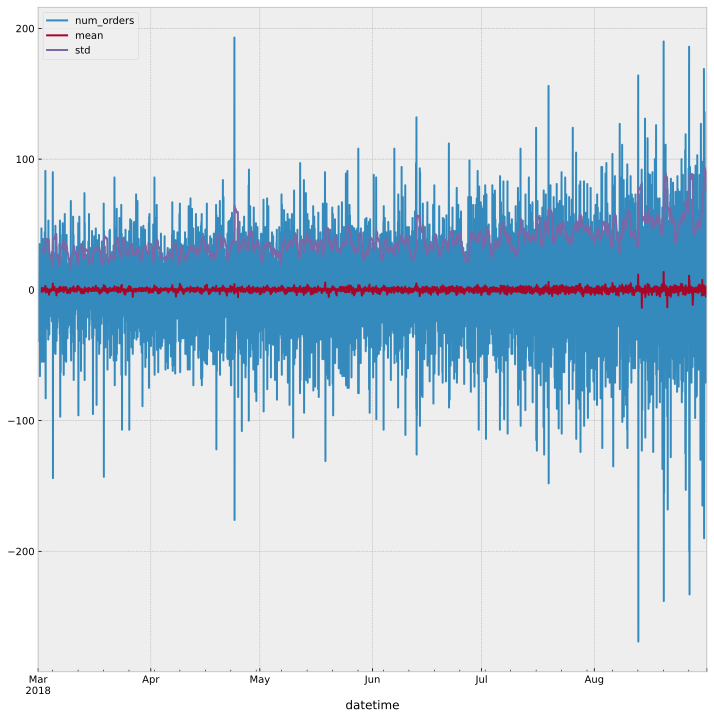

In [31]:
# выравниванием данные и визуализируем их распределение
data_temp = data_temp - data_temp.shift()
data_temp['mean'] = data_temp['num_orders'].rolling(24).mean()
data_temp['std'] = data_temp['num_orders'].rolling(24).std()
data_temp.plot()
plt.show()

Вариативность стандартного отклонения уменьшилась незначительно, но судя по значениям среднего временной ряд стал гораздо более стационарным. Несмотря на это для машинного обучения будут использованы данные временного ряда без выравнивания, т.к. будут созданы дополнительыне признаки.

### **Выводы по 2.2 Анализ временных рядов датасета**

---

**(1)** проведенный анализ декомпозиции данных позволил выявить тренд, сезонность и шумовые данные

**(2)** график, отражающий тренд, показывает значительное увеличение среднего количества заказов такси в летние месяцы, особенно в августе

**(3)** исследование сезонности по каждому из шести месяцев по которым представлена информация в датасете, показало, что ежедневно минимальное количество заказов такси фиксируется с полуночи до раннего утра, в течении дня количество вызовов такси увеличивается, достигая пика с 22 до 24 часов

**(4)** с помощью сдвига вдоль временной оси на один шаг назад исследовано, как изменится распределение данных. В результате получен более стационарный временной ряд. Несмотря на это для машинного обучения будет использован несмещенный временной ряд, т.к. будут созданы новые признаки на основе даты/времени наблюдения

### **2.3 Создание признаков**

---

Датасет содержит индексы, которыми являются дата и время наблюдения, и признак 'num_orders', который будет целевым признаком для машинного обучения. Соответственно, для обучения моделей необходимо создать признаки на основе индексов с датой и временем.

Создадим признаки, включающие три компонента:

 * календарные признаки

 * отстающие значения

 * скользящее среднее

Перед созданием обучающих признаков создадим копию датасета, которая потребуется для определения качества полученных предсказаний.

Проверка качества предсказаний для временных рядов может быть проведена с помощью:

 1. предсказания новых значений предыдущими

 2. предсказания по среднему значению

In [32]:
# сформируем функцию, которая позволит создать
# необходимое количество признаков
def make_features(data, max_lag, rolling_mean_size):
    """ календарных признаков будет создано три: день, день недели и час,
        т.к. месяцев всего шесть, не все месяцы будут
        одновременно присутствовать в обучающей и тестовой выборках,
        формируемых без перемешивания
    """
    new_data = data.copy()

    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour

    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(
        rolling_mean_size).mean()

    return new_data

Проверим работоспособность функции make_features и сформируем новый датасет с признаками.

In [33]:
# сформируем новый датасет с признаками
data_for_def = make_features(data_resampled, 2, 3)

In [34]:
# для проверки работы функции, формирующей признаки,
# выведем первые пять строк датасета с признаками
data_for_def.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,74.000000


Мы убедились, что функция работает корректно. Созданный для проверки работы датасет можно удалить.

In [35]:
# удаляем датасет для оптимизации загрузки RAM
del data_for_def

In [36]:
# для проверки выведем первые пять строк датасета data_resampled
data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## **<font color='mediumblue'>ВЫВОДЫ по 2 Исследовательский анализ данных</font>**

---

**(1)** исследовательский анализ данных показал что ‘стандартные’ приемы предобработки данных применять не требуется; обработка данных была проведена с использованием инструментов, разработанных целенаправленно для датасетов с временным рядом

**(2)** декомпозиция временного ряда позволила выявить тренд и сезонность. Тренд отражает тенденцию увеличения количества заказов такси в летние месяцы, особенно в августе. Детальное изучение сезонности по месяцам позволило установить, что ежедневно минимальное число заказов такси приходится на часы с 0:00 до примерно 6:00 утра. В течении дня число заказов планомерно растет, достигая пика с 22:00 до 0:00

**(3)** проведена проверка датасета на стационарность. Проведено выравнивание данных с помощью функции .shift(). Установлено, что применение выравнивания позволяет получить более стационарный датасет. Несмотря на это для машинного обучения будет использоваться ресэмплированный по одному часу датасет без выравнивнаия, т.к. с помощью функции будут созданы новые обучающие признаки

**(4)** сформирована функция make_features, позволяющая создать признаки на основе даты и времени наблюдения

## <font color='green'>**3 Обучение моделей разных классов**</font>

---

### **3.1 Обоснование методики обучения каждого класса моделей**

---

Подробно опишем суть подхода, который будет применен для машинного обучения и выявления лучшей модели в каждом исследуемом классе.

При машинном обучении на основе временных рядов гиперпараметры делятся на две большие группы:

 1. гиперпараметры временного ряда (смещение / максимальный лаг; скользящее окно)

 2. гиперпараметры модели

Для того, чтобы одновременно подобрать и первую, и вторую группу гиперпараметров, исключив ручной перебор, одновременно задействуем цикл for и RandomizedSearchCV.

Таким образом, традиционный подход поиска лучшей модели с помощью кросс-валидации, реализованный в том числе с помощью GridSearchCV и RandomizedSearchCV, будет ‘завернут’ в цикл for.

Гиперпараметры временного ряда будут подбираться во внешнем цикле for. Гиперпараметры лучшей модели будут подбираться во внутренней кроссвалидации с использованием RandomizedSearchCV.

Особо подчеркнем, что кроссвалидация будет проводиться с использованием инструмента из библиотеки sklearn, специально разработанного для кроссвалидации моделей на временных рядах: TimeSeriesSplit(), - исключающего перемешивание выборок, реализуемого при машинном обучении в ‘классических’ задачах регрессии и классификации.

На каждой итерации работы цикла for с помощью подготовленной функции make_features будет создаваться новый датасет с уникальным набором признаков.

В случае нахождения модели с RMSE меньшим, чем 48, необходимые данные будут сохраняться в семь объектов:

 1. лучшее смещение (лучший максимальный лаг)

 2. лучшее скользящее окно

 3. лучшая модель

 4. гиперпараметры лучшей модели

 5. лучшее значение метрики RMSE

 6. выборка с тестовыми признаками, полученная при выявлении лучшей модели, - для финальной проверки

 7. целевой признак тестовой выборки, полученной при выявлении лучшей модели, - для финальной проверки

В ходе работы цикла for и многократного вызова функции make_features будут созданы десятки разных датасетов с признаками. В финале проекта будет проводиться тестирование лучшей модели, и для этой проверки будут сохранены необходимые датасеты.

Особым элементом обучения каждого класса моделей станет оптимизация загруженности оперативной памяти. В конце каждой итерации работы цикла for будет удаляться семь файлов. При начале каждой новой итерации. созданные на предыдущем шаге объекты/датасеты последовательно могли бы быть перезаписаны. Однако, удаление тех объектов/датасетов, которые точно не понадобятся в последующей части проекта и/или итерации, будет немного, но все же снижать текущую загрузку RAM.

После полного завершения работы цикла for будут полностью удаляться объекты/датасеты, которые не будут использоваться в последующей части проекта. Они аналогично могли бы быть перезаписаны при обучении следующей модели и удалены после завершения обучения всех моделей, однако любая, даже небольшая оптимизация загрузки RAM будет полезна для обеспечения стабильности выполнения проекта.

Перед обучением моделей различных классов будет создано две базовые модели, позволяющие прогнозировать временные ряды без обучения двумя способами:

 * все значения тестовой выборки предсказываются одним и тем же числом (константой)

 * новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1), - этот способ не зависит от метрики

**Диапазон значений гиперпараметров временного ряда, который будет перебираться в цикле for, - range(3, 50, 3), - намеренно составлен так, чтобы в него вошли как кратные количеству часов в сутках значения [24, 48], так и иные значения**.


### **3.2 Первая базовая модель: получение прогноза с помощью константы**

---

Для определения метрики RMSE первой базовой модели за константное значение примем среднее значение тестовой выборки.

In [37]:
# для первой и второй базовой модели разделим
# датасет data_resampled на обучающую и тестовую выборки
train, test = train_test_split(
    data_resampled,
    shuffle = False,
    test_size = 0.1
)

In [38]:
# вычислим среднее количество заказов такси в тестовой выборке
print('Средний объем заказов такси:\n',
      round(test['num_orders'].mean(), 3),
      'вызовов в час')

Средний объем заказов такси:
 139.557 вызовов в час


Данные были выровнены для машинного обучения, диапазон значений включает значения с отрицательным знаком, именно поэтому среднее количество заказов такси находится на околонулевом уровне.

In [39]:
# получим предсказания с помощью константного значения
pred_baseline_1 = np.ones(test.shape) * test['num_orders'].mean()

In [40]:
# вычислим значение метрики RMSE первой констатной модели
rmse_baseline_1 = round(mean_squared_error(
    test, pred_baseline_1) ** (0.5), 3
)

print(f'RMSE первой констатной модели равно:\n {rmse_baseline_1}')

RMSE первой констатной модели равно:
 58.55


### **3.3 Вторая базовая модель: получение прогноза с помощью предыдущих значений временного ряда**

---

Для определения метрики RMSE второй базовой модели получим предсказания с помощью предыдущих значений временного ряда.

In [41]:
# получим предсказания по предыдущим значениям временного ряда
pred_baseline_2 = test['num_orders'].shift()

In [42]:
# заполним первое пропущенное значение в полученных предсказаниях
pred_baseline_2.iloc[0] = train.iloc[-1]

In [43]:
# вычислим значение метрики RMSE второй констатной модели
rmse_baseline_2 = round(mean_squared_error(
    test, pred_baseline_2) ** (0.5), 3
)

print(f'RMSE первой констатной модели равно:\n {rmse_baseline_2}')

RMSE первой констатной модели равно:
 58.856


In [44]:
# удаляем ненужные датасеты
del train
del test
del pred_baseline_1
del pred_baseline_2

### **3.4 Обучение модели Ridge**

---

In [45]:
%%time

ridge_best_lag = 0
ridge_best_roll_size = 0
ridge_best_model = None
ridge_best_params = None
ridge_best_rmse = 48
ridge_test_features = None
ridge_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_ridge = Ridge(random_state = 1, copy_X = False)
        params_ridge =  {'alpha': np.logspace(-3, 10, num = 30)}

        random_model_ridge = RandomizedSearchCV(
        model_ridge,
        params_ridge,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_ridge.fit(train_features,
                              train_target)

        ridge_rmse = abs(random_model_ridge.best_score_)

        if ridge_rmse < ridge_best_rmse:
            ridge_best_lag = lag
            ridge_best_roll_size = roll
            ridge_best_model = random_model_ridge.best_estimator_
            ridge_best_params = random_model_ridge.best_params_
            ridge_best_rmse = round(ridge_rmse, 3)
            ridge_test_features = test_features
            ridge_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели Ridge на обучающей выборке: {ridge_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {ridge_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {ridge_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {ridge_best_params}')
print('--------------------')

RMSE лучшей модели Ridge на обучающей выборке: 24.685
--------------------
Смещение лучшей модели: 48
--------------------
Скользящее окно лучшей модели: 6
--------------------
Гиперпараметры лучшей модели: {'alpha': 41753.189365604005}
--------------------
CPU times: user 36.2 s, sys: 18.8 s, total: 55 s
Wall time: 2min 16s


### **3.5 Обучение модели DecisionTreeRegressor**

---

In [46]:
%%time

tree_best_lag = 0
tree_best_roll_size = 0
tree_best_model = None
tree_best_params = None
tree_best_rmse = 48
tree_test_features = None
tree_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_tree = DecisionTreeRegressor(random_state = 1)
        params_tree =  {'max_depth': range(1, 51, 10),
                'min_samples_split': range(1, 21, 5),
                'min_samples_leaf': range(1, 21, 5),
                'max_features': range(1, 13, 4)
                       }

        random_model_tree = RandomizedSearchCV(
        model_tree,
        params_tree,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_tree.fit(train_features,
                              train_target)

        tree_rmse = abs(random_model_tree.best_score_)

        if tree_rmse < tree_best_rmse:
            tree_best_lag = lag
            tree_best_roll_size = roll
            tree_best_model = random_model_tree.best_estimator_
            tree_best_params = random_model_tree.best_params_
            tree_best_rmse = round(tree_rmse, 3)
            tree_test_features = test_features
            tree_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели DTR на обучающей выборке: {tree_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {tree_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {tree_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {tree_best_params}')
print('--------------------')

RMSE лучшей модели DTR на обучающей выборке: 26.953
--------------------
Смещение лучшей модели: 3
--------------------
Скользящее окно лучшей модели: 9
--------------------
Гиперпараметры лучшей модели: {'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 9, 'max_depth': 41}
--------------------
CPU times: user 34.8 s, sys: 1.66 s, total: 36.5 s
Wall time: 2min 16s


### **3.6 Обучение модели CatBoostRegressor**

---

In [47]:
%%time

catboost_best_lag = 0
catboost_best_roll_size = 0
catboost_best_model = None
catboost_best_params = None
catboost_best_rmse = 48
catboost_test_features = None
catboost_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_catboost = CatBoostRegressor(
            random_state = 1,
            logging_level = 'Silent')

        params_catboost = {
          'n_estimators': [30, 50]
    }

        random_model_catboost = RandomizedSearchCV(
        model_catboost,
        params_catboost,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_catboost.fit(train_features,
                              train_target)

        catboost_rmse = abs(random_model_catboost.best_score_)

        if catboost_rmse < catboost_best_rmse:
            catboost_best_lag = lag
            catboost_best_roll_size = roll
            catboost_best_model = random_model_catboost.best_estimator_
            catboost_best_params = random_model_catboost.best_params_
            catboost_best_rmse = round(catboost_rmse, 3)
            catboost_train_features = train_features
            catboost_train_target = train_target
            catboost_test_features = test_features
            catboost_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели CatBoost на обучающей выборке: {catboost_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {catboost_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {catboost_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {catboost_best_params}')
print('--------------------')

RMSE лучшей модели CatBoost на обучающей выборке: 25.026
--------------------
Смещение лучшей модели: 48
--------------------
Скользящее окно лучшей модели: 27
--------------------
Гиперпараметры лучшей модели: {'n_estimators': 30}
--------------------
CPU times: user 2min 31s, sys: 6.48 s, total: 2min 37s
Wall time: 13min 27s


### **3.7 Обучение модели HistGradientBoostingRegressor**

---

In [48]:
%%time

hist_best_lag = 0
hist_best_roll_size = 0
hist_best_model = None
hist_best_params = None
hist_best_rmse = 48
hist_test_features = None
hist_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_hist = HistGradientBoostingRegressor(random_state = 1)

        params_hist = {
    'max_depth': [30, 50]
     }

        random_model_hist = RandomizedSearchCV(
        model_hist,
        params_hist,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_hist.fit(train_features,
                              train_target)

        hist_rmse = abs(random_model_hist.best_score_)

        if hist_rmse < hist_best_rmse:
            hist_best_lag = lag
            hist_best_roll_size = roll
            hist_best_model = random_model_hist.best_estimator_
            hist_best_params = random_model_hist.best_params_
            hist_best_rmse = round(hist_rmse, 3)
            hist_test_features = test_features
            hist_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели HGBR на обучающей выборке: {hist_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {hist_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {hist_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {hist_best_params}')
print('--------------------')

RMSE лучшей модели HGBR на обучающей выборке: 24.029
--------------------
Смещение лучшей модели: 48
--------------------
Скользящее окно лучшей модели: 9
--------------------
Гиперпараметры лучшей модели: {'max_depth': 30}
--------------------
CPU times: user 6min 29s, sys: 8.94 s, total: 6min 38s
Wall time: 22min 25s


### **3.8 Обучение модели LGBMRegressor**

---

In [49]:
%%time

lgbmr_best_lag = 0
lgbmr_best_roll_size = 0
lgbmr_best_model = None
lgbmr_best_params = None
lgbmr_best_rmse = 48
lgbmr_test_features = None
lgbmr_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_lgbmr = LGBMRegressor(random_state = 1)
        params_lgbmr = {
    'max_depth': [30, 50],
    }

        random_model_lgbmr = RandomizedSearchCV(
        model_lgbmr,
        params_lgbmr,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_lgbmr.fit(train_features,
                              train_target)

        lgbmr_rmse = abs(random_model_lgbmr.best_score_)

        if lgbmr_rmse < lgbmr_best_rmse:
            lgbmr_best_lag = lag
            lgbmr_best_roll_size = roll
            lgbmr_best_model = random_model_lgbmr.best_estimator_
            lgbmr_best_params = random_model_lgbmr.best_params_
            lgbmr_best_rmse = round(lgbmr_rmse, 3)
            lgbmr_test_features = test_features
            lgbmr_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели LGBMRegressor на обучающей выборке: {lgbmr_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {lgbmr_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {lgbmr_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {lgbmr_best_params}')
print('--------------------')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 3971, number of used features: 7
[LightGBM] [Info] Start training from score 78.279275
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=tr

### **3.9 Третья базовая модель: DummyRegressor**

---

In [50]:
%%time

dummy_best_lag = 0
dummy_best_roll_size = 0
dummy_best_model = None
dummy_best_params = None
dummy_best_rmse = 48
dummy_test_features = None
dummy_test_target = None

for lag in range(3, 50, 3):
    for roll in range(3, 50, 3):

        data_temp = make_features(data_resampled, lag, roll)
        train, test = train_test_split(data_temp,
                                       shuffle = False,
                                       test_size = 0.1)
        train = train.dropna()
        train_features = train.drop('num_orders', axis = 1)
        train_target = train['num_orders']
        test_features = test.drop('num_orders', axis = 1)
        test_target = test['num_orders']

        cv = TimeSeriesSplit()
        model_dummy = DummyRegressor()
        params_dummy =  {'strategy': ['mean', 'median']
                       }

        random_model_dummy = RandomizedSearchCV(
        model_dummy,
        params_dummy,
        scoring = 'neg_root_mean_squared_error',
        n_jobs= -1,
        refit = True,
        cv = cv,
        random_state = 1)

        random_model_dummy.fit(train_features,
                              train_target)

        dummy_rmse = abs(random_model_dummy.best_score_)

        if dummy_rmse < dummy_best_rmse:
            dummy_best_lag = lag
            dummy_best_roll_size = roll
            dummy_best_model = random_model_dummy.best_estimator_
            dummy_best_params = random_model_dummy.best_params_
            dummy_best_rmse = round(dummy_rmse, 3)
            dummy_test_features = test_features
            dummy_test_target = test_target

        del data_temp
        del train
        del test
        del train_features
        del train_target
        del test_features
        del test_target

print(f'RMSE лучшей модели DummyRegressor на обучающей выборке: {dummy_best_rmse}')
print('--------------------')
print(f'Смещение лучшей модели: {dummy_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {dummy_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {dummy_best_params}')
print('--------------------')

RMSE лучшей модели DummyRegressor на обучающей выборке: 40.471
--------------------
Смещение лучшей модели: 3
--------------------
Скользящее окно лучшей модели: 18
--------------------
Гиперпараметры лучшей модели: {'strategy': 'mean'}
--------------------
CPU times: user 14.1 s, sys: 641 ms, total: 14.8 s
Wall time: 31.8 s


### **3.10 Сводные результаты обучения моделей**

---

In [51]:
# в сводной таблице представим результаты обучения моделей
ml_results = pd.DataFrame([
    ['Базовая модель 1*', rmse_baseline_1, '-', '-'],
    ['Базовая модель 2*', rmse_baseline_2, '-', '-'],
    ['DummyRegressor', dummy_best_rmse, dummy_best_lag, dummy_best_roll_size],
    ['Ridge', ridge_best_rmse, ridge_best_lag, ridge_best_roll_size],
    ['DTreeRegressor', tree_best_rmse, tree_best_lag, tree_best_roll_size],
    ['CatBoost', catboost_best_rmse, catboost_best_lag, catboost_best_roll_size],
    ['HistGBR', hist_best_rmse, hist_best_lag, hist_best_roll_size],
    ['LGBMRegressor', lgbmr_best_rmse, lgbmr_best_lag, lgbmr_best_roll_size]
],
columns = ['Модель', 'RMSE', 'Смещение (лаг)', 'Скользящее окно'])

# выведем таблицу на экран
ml_results

,Модель,RMSE,Смещение (лаг),Скользящее окно
0,Базовая модель 1*,58.550,-,-
1,Базовая модель 2*,58.856,-,-
2,DummyRegressor,40.471,3,18
3,Ridge,24.685,48,6
4,DTreeRegressor,26.953,3,9
5,CatBoost,25.026,48,27
6,HistGBR,24.029,48,9
7,LGBMRegressor,23.983,48,9


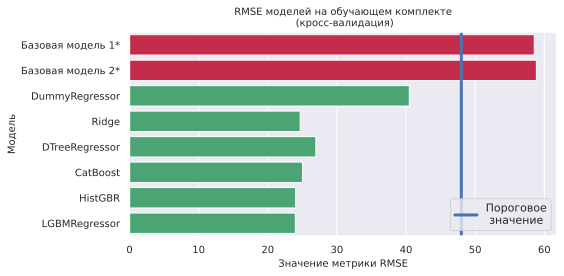

In [52]:
bar_values = ml_results['RMSE']
bar_color = ['mediumseagreen' if (x <= 48) else 'crimson' for x in bar_values ]

sns.set(rc={'figure.figsize':(8,4)})
c = sns.barplot(data = ml_results,
    x = 'RMSE',
    y = 'Модель',
    palette = bar_color)
c.axes.set_title('RMSE моделей на обучающем комплекте\n (кросс-валидация)',fontsize=10)
c.set_xlabel('Значение метрики RMSE',fontsize=10)
c.set_ylabel('Модель',fontsize=10)
c.tick_params(labelsize=10)
plt.axvline(48, linewidth = 3, label = 'Пороговое\n значение')
plt.legend()
plt.tight_layout()
plt.show()

***Результаты базовых моделей 1 и 2** в таблице и на рисунке приведены **справочно**, т.к. их предсказания получены без обучения моделей на исходном датасете, разделенном в соотношении 0.9/0.1 без выделения обучающего и тестового комплекта.

## **<font color='mediumblue'>ВЫВОДЫ по 3 Обучение моделей разных классов</font>**

---

**(1)** подробно обоснована методика обучения каждого класса моделей, включающая подбор гиперпараметров по двум большим группам:

 * гиперпараметры временного ряда

 * гиперпараметры модели

Для того, чтобы одновременно подобрать и первую, и вторую группу гиперпараметров, исключив ручной перебор, одновременно были задействованы цикл for и RandomizedSearchCV. Для кроссвалидации временного ряда был использован TimeSeriesSplit()

**(2)** проведено обучение моделей пяти разных классов: Ridge, DecisionTreeRegressor, CatBoostRegressor, HistGradientBoostingRegressor, LightGBMRegressor.

**(3)** для оценки качества обучения моделей были сформированы две базисные модели, позволяющие получить предсказание без обучения (предсказание с помощью константы; предсказание с помощью предыдущих значений временного ряда). Дополнительно получены предсказания модели DummyRegressor, которая согласно общепринятой практике применяется для оценки качества в задачах регрессии

**(4)** **самый лучший результат** из обученных моделей показала **LGBMRegressor**, - именно она будет проверена на тестовой выборке. Лучшая модель LGBMRegressor сохранена в переменной **lgbmr_best_model**

**(5)** результаты предсказаний базовых моделей 1и 2 значительно хуже, чем у остальных моделей, причем ошибка предсказаний обоих базовых моделей превышает пороговый уровень. Результат предсказания модели DummyRegressor на обучающей выборке соответствует пороговому уровню, но хуже, чем у пяти исследуемых моделей

**(6)** среди гиперпараметров временного ряда лучшим чаще всего становился '48' - кратный количеству часов в сутках

## <font color='green'>**4 Проверка лучшей модели на тестовой выборке**</font>

---

### **4.1 Тестирование лучшей модели**

---

In [53]:
# получим предсказания модели LGBMRegressor
# на признаках тестового комплекта
lgbmr_test_predict = lgbmr_best_model.predict(lgbmr_test_features)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [54]:
# вычислим метрику RMSE лучшей модели на тестовой выборке
rmse_lgbmr_test = round(
    mean_squared_error(
        lgbmr_test_target, lgbmr_test_predict) ** (0.5), 3)

print(f'RMSE лучшей модели на тестовой выборке:\n {rmse_lgbmr_test}')

RMSE лучшей модели на тестовой выборке:
 39.46


Значение метрики RMSE лучшей модели на тестовой выборке соответствует пороговому уровню.

Проверим значение метрики RMSE на тестовой выборке для модели DummyRegressor.

In [55]:
# получим предсказания модели DummyRegressor
# на признаках тестового комплекта
dummy_test_predict = dummy_best_model.predict(dummy_test_features)

In [56]:
# вычислим метрику RMSE модели DummyRegressor на тестовой выборке
rmse_dummy_test = round(
    mean_squared_error(
        dummy_test_target, dummy_test_predict) ** (0.5), 3)

print(f'RMSE модели DummyRegressor на тестовой выборке:\n {rmse_dummy_test}')

RMSE модели DummyRegressor на тестовой выборке:
 84.66


Результат модели DummyRegressor значительно уступает результату лучшей модели LGBMRegressor, что подтвреждает достаточный уровень  качества обучения модели LGBMRegressor. Обратим внимание, что результат модели DummyRegressor на тестовой выборке равен результату, полученному по предсказаниям базовой модели 1.

**Модель LGBMRegressor полностью соответствует установленным в техзадании требованиям**.

Чтобы лучше понять, как именно предсказывает количество вызовов такси на следующий час лучшая модель, изобразим на графике правильные значения тестовой выборки и предсказанные моделью значения.

In [57]:
# предсказания модели переведем в тип Series
lgbmr_test_predict = pd.Series(
    lgbmr_test_predict,
    index = lgbmr_test_target.index,
    name = 'predicted_values'
)

In [58]:
# создадим датасет, объединяющий предсказанные и реальные значения
lgbmr_target_vs_predict = pd.concat(
    [lgbmr_test_target,
     lgbmr_test_predict],
     axis = 1
)

# выведем первые пять строк созданного датасета
lgbmr_target_vs_predict.head()

,num_orders,predicted_values
datetime,,
2018-08-13 14:00:00,102,103.259778
2018-08-13 15:00:00,175,136.467614
2018-08-13 16:00:00,144,163.878565
2018-08-13 17:00:00,152,149.182921
2018-08-13 18:00:00,104,94.038704


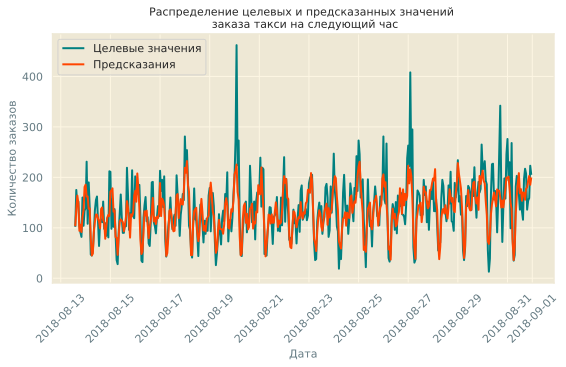

In [59]:
plt.figure(figsize=(9, 4.5))
plt.style.use('Solarize_Light2')
sns.lineplot(
    x = lgbmr_target_vs_predict.index,
    y = lgbmr_target_vs_predict['num_orders'],
    label = 'Целевые значения',
    color = 'teal')
sns.lineplot(
    x = lgbmr_target_vs_predict.index,
    y = lgbmr_target_vs_predict['predicted_values'],
    label = 'Предсказания',
    color = 'orangered')
plt.xlabel('Дата',fontsize = 11)
plt.ylabel('Количество заказов',fontsize = 11)
plt.xticks(rotation = 45)
plt.title('Распределение целевых и предсказанных значений \n заказа такси на следующий час',
          fontsize = 11)
plt.show()

Мы видим, что модель допускает ошибки в основном в предсказании пиковых значений. По формальным признакам они могут быть отнесены к выбросам, но применительно к рассматриваемой задаче удалять их нельзя, т.к. пиковые значения заказов такси будут иметь место и модель должна их предсказывать. Поэтому на этапе предобработки пиковые значения не были удалены.

## **<font color='mediumblue'>ВЫВОДЫ по 4 Проверка лучшей модели на тестовой выборке</font>**

---

**(1)** показавшая лучшие результаты на обучающей выборке модель LGBMRegressor успешно прошла проверку на тестовой выборке: значение метрики RMSE составило 39.46, что ниже установленного порогового значения в 48

**(2)** модель DummyRegressor на тестовой выборке показала значение метрики RMSE в 58.856, что подтверждает достаточный уровень качества модели LGBMRegressor

**(3)** визуализация предсказаний модели LGBMRegressor на тестовой выборке в сравнении с целевыми значениями показала, что модель недостаточно предсказывает пиковые значения (в основном максимальные), однако ошибка предсказаний (RMSE) не превышает пороговый уровень

# **<font color='crimson'>ИТОГОВЫЕ ВЫВОДЫ ПО ПРОЕКТУ «Прогнозирование количества заказов такси на следующий час для компании „ Чётенькое такси ‟»</font>**

**(1)** в рамках исследовательского анализа данные были ресэмплированы по одному часу. Построены графики, отражающие распределение данных до и после ресэмплирования:

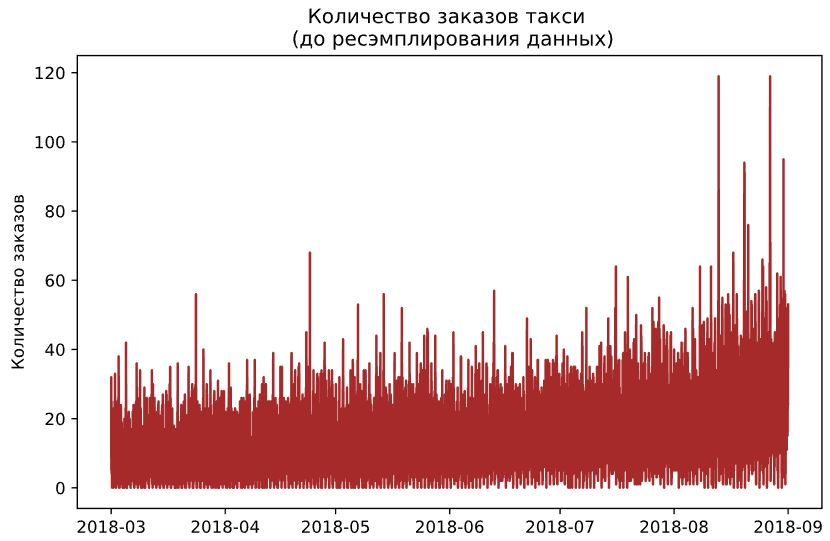

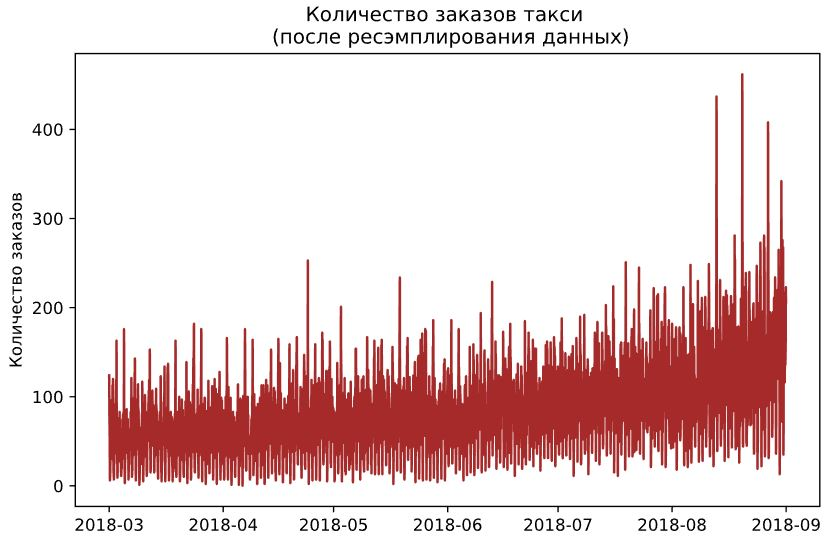

**(2)** с помощью функции декомпозиции выявлены тренд и сезонность, которые были представлены на графиках. Сезонность дополнительно была исследована для каждого месяца. Тренд показывает значительное увеличение среднего количества заказов такси в летние месяцы, особенно в августе. исследование сезонности по каждому из шести месяцев по которым представлена информация в датасете, показало, что ежедневно минимальное количество заказов такси фиксируется с полуночи до раннего утра, в течении дня количество вызовов такси увеличивается, достигая пика с 22 до 24 часов

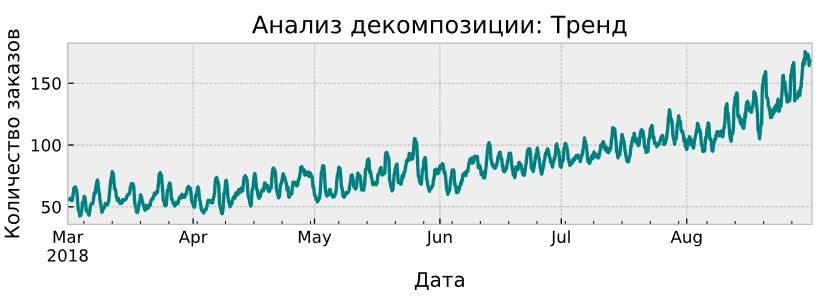

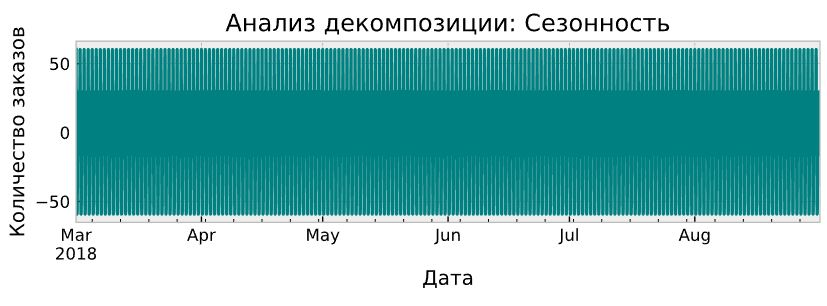

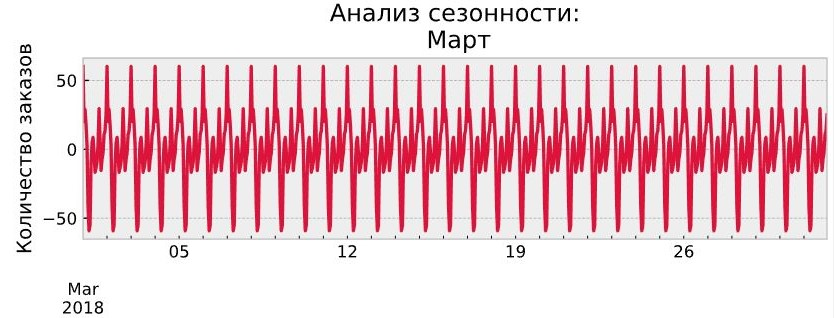

**(3)** с помощью сдвига вдоль временной оси на один шаг назад исследовано выравнивание данных, в результате чего получен более стационарный временной ряд. Для обучения модели был использован ресэмплированный по одному часу датасет без выравнивания временного ряда.

Распределение данных до выравнивания:


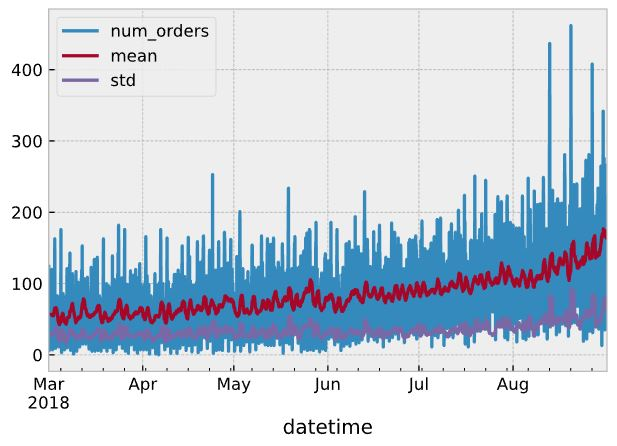

Распределение данных после выравнивания:

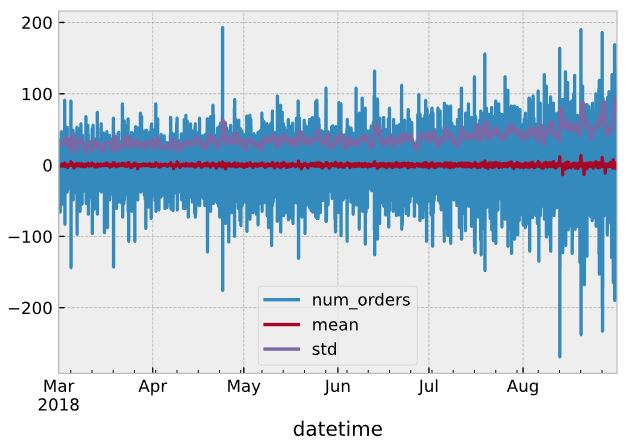

**(4)** для создания признаков для машинного обучения была сформирована функция make_features, возвращающая датасет с вновь созданными на основе даты/времени наблюдения признаками трех типов:

 * календарные признаки

 * отстающие значения

 * скользящее среднее

**(5)** для выявления лучшей было проведено обучение следующих моделей:

 * Ridge

 * DecisionTreeRegressor

 * CatBoost

 * HistGradientBoostingRegressor

 * LightGBMPergessor

**(6)** для оценки качества модели было создано две базовые модели, предсказания на которых могут быть получены без обучения:

 * получение прогноза с помощью константы

 * получение прогноза с помощью предыдущих значений временного ряда

Дополнительно было получено значение метрики RMSE на модели DymmyRegressor, традиционно применяемой в задачах регрессии для оценки качества модели

**(7)** на обучающей выборке исследуемые модели показали следующее значение метрики RMSE при подобранных гиперпараметрах временного ряда:

In [60]:
ml_results

,Модель,RMSE,Смещение (лаг),Скользящее окно
0,Базовая модель 1*,58.550,-,-
1,Базовая модель 2*,58.856,-,-
2,DummyRegressor,40.471,3,18
3,Ridge,24.685,48,6
4,DTreeRegressor,26.953,3,9
5,CatBoost,25.026,48,27
6,HistGBR,24.029,48,9
7,LGBMRegressor,23.983,48,9


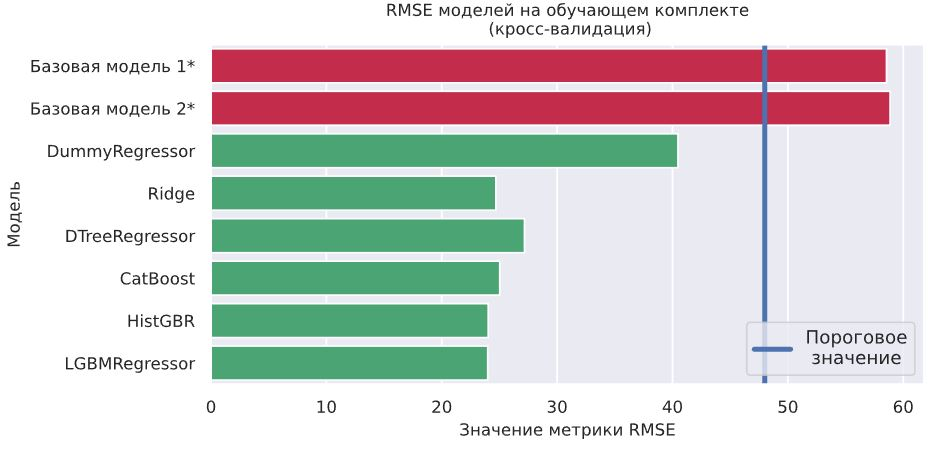

Результаты базовых моделей 1 и 2 в таблице и на рисунке приведены справочно, т.к. их предсказания получены без обучения моделей на исходном датасете, разделенном в соотношении 0.9/0.1 без выделения обучающего и тестового комплекта. Результаты предсказаний базовых моделей 1и 2 значительно хуже, чем у остальных моделей, причем ошибка предсказаний обоих базовых моделей превышает пороговый уровень. Результат предсказания модели DummyRegressor на обучающей выборке соответствует пороговому уровню, но хуже, чем у пяти исследуемых моделей

**(8)** самый лучший результат из пяти обученных моделей показала LGBMRegressor. Модель успешно прошла проверку на тестовой выборке, показав значение метрики RMSE 39.46. Значение метрики RMSE на тестовой выборке модели DummyRegressor 84.66. Таким образом, **модель LGBMRegressor полностью соответствует установленным в техзадании требованиям**

**(9)** визуализация предсказаний модели LGBMRegressor на тестовой выборке в сравнении с целевыми значениями показала, что модель недостаточно точно предсказывает пиковые значения (в основном максимальные), однако ошибка предсказаний (метрика RMSE) не превышает пороговый уровень



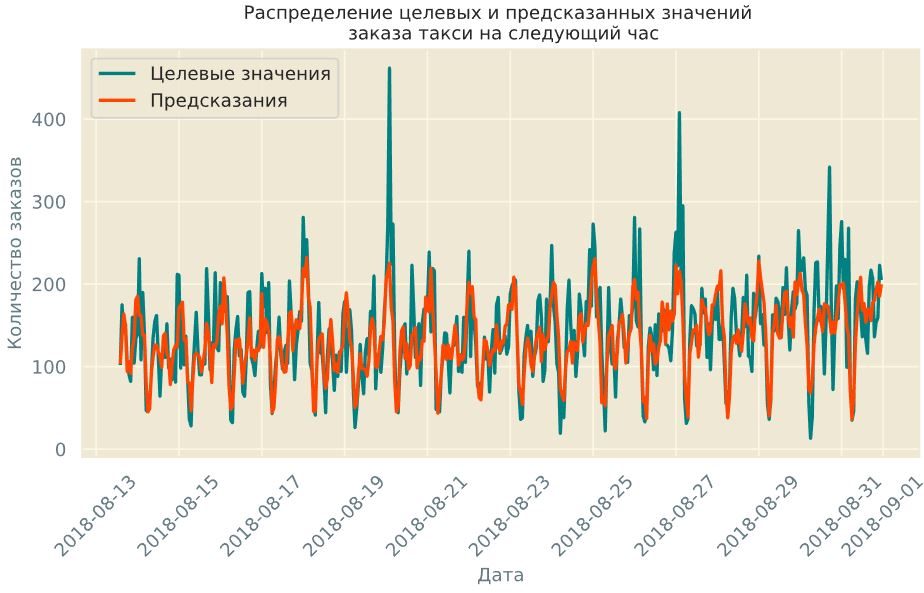

**(10)** среди гиперпараметров временного ряда лучшим чаще всгео становился '48' - кратный количеству часов в сутках